# Cobertura del suelo MODIS
_Autor:_    __Jesús Casado__ <br> _Revisión:_ __04/0/2020__ <br>

__Introducción__<br>
Datos de MODIS sobre clasificación de la cobertur adel suelo:
1. Se cargan los datos originales (anual). Los datos se muestran en mapas y series.

__Cosas que arreglar__ <br>


__Fuentes__<br>
[Clasificación de usos: MCD12Q1](https://lpdaac.usgs.gov/products/mcd12q1v006/)<br>
[Fenología: MCD12Q2](https://lpdaac.usgs.gov/products/mcd12q2v006/)<br>
[Explicación productos y unidades](https://lpdaac.usgs.gov/documents/101/MCD12_User_Guide_V6.pdf)<br>
***

__Índice__ <br>
__[Datos](#Datos)__<br>
[DEM de la cuenca](#DEM-de-la-cuenca-(ETRS89-UTM30N))<br>
[Evapotranspiración MODIS](#Evapotranspiración-MODIS)<br>

__[Análisis](#Análisis)__<br>
[8 diario](#8-diario)<br>
[Mensual](#Mensual)<br>
[Anual](#Anual)<br>
[EOF](#EOF)<br>

In [1]:
import numpy as np
import pandas as pd

from netCDF4 import Dataset, num2date, date2num
#import h5py
from datetime import datetime
from calendar import monthrange
import time

import os
rutaBase = os.getcwd().replace('\\', '/') + '/'

import geopandas as gpd
import earthpy as et

from eofs.standard import Eof

import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
from pyproj import Proj, transform, CRS
os.environ['PROJ_LIB'] = r'C:\Anaconda3\pkgs\proj4-4.9.3-vc14_5\Library\share'

In [3]:
os.chdir(rutaBase + '../src/')
from funciones_MODIS import *
from funciones_EOF import *
os.chdir(rutaBase)

In [4]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.style.use('dark_background')
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set()
custom_style = {'axes.facecolor': 'k',
                'axes.edgecolor': 'gray',
                'axes.labelcolor': 'white',
                'figure.facecolor': 'k',
                'grid.color': 'gray',
                'text.color': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white',
                "xtick.major.size": 0,
                "ytick.major.size": 0}
sns.set_style(style='darkgrid', rc=custom_style)

***

## Datos
### MODIS
#### Configuración

In [5]:
# satélites, productos, variable, unidades, valor correspondiente a NaN y
# factor multiplicativo
satellites = ['MODIS']
products = ['MCD12Q1']
var = 'PFT'
units = '-'
fillValue = [255]
factor = None

In [6]:
# coberturas del suelo definidas en la clasificación PFT (plant functional types)
MODISclass = {0: 'Water bodies',
              1: 'Evergreen needleleaf trees',
              2: 'Evergreen broadleaf trees',
              3: 'Deciduous needleleaf trees',
              4: 'Deciduous broadleaf trees',
              5: 'Shrub',
              6: 'Grass',
              7: 'Cereal croplands',
              8: 'Broadleaf croplands',
              9: 'Urban and built-up lands',
              10: 'Permanent snow and ice',
              11: 'Barren',
              255: 'Unclassified'}

In [7]:
# ruta y nombre del archivo
rutaExport = rutaBase + '../output/' + var + '/'
if os.path.exists(rutaExport) == False:
    os.makedirs(rutaExport)
filename = 'MODIS_' + var + '_Deva.nc'

In [8]:
if os.path.exists(rutaExport + filename) == False:
    # EXTRAER DATOS
    # -------------
    Data = {sat: {} for sat in satellites}
    for sat, product in zip(satellites, products):
        print('{0}: {1}'.format(sat, product))
        rutaAsc = 'F:/Cartografia/MODIS/' + product + '/'
        MODISfromASC(rutaAsc, product, factor, fillValue)
        Data[sat][var] = MODISfromASC.data
        Data[sat]['dates'] = MODISfromASC.dates
        Data[sat]['Y'] = MODISfromASC.Y
        Data[sat]['X'] = MODISfromASC.X
        print()
        

    # GUARDAR NETCDF
    # --------------
    MODISnc(rutaExport + filename, Data, var, units, sats=satellites)

In [9]:
# IMPORTAR NETCDF
# ---------------
# Cargar netcdf con los datos MODIS
ncRead = Dataset(rutaExport + filename, 'r', format='NETCDF4')

# extraer datos en un diccionario
Data = {sat: {} for sat in satellites}
for sat, product in zip(satellites, products):
    # evapotranspiración
    Data[sat][var] = ncRead[sat][var][::]
    # fechas
    Data[sat]['dates'] = [datetime(1, 1, 1) + timedelta(time) for time in ncRead[sat]['time'][:]]
    # coordenadas
    Data[sat]['X'] = ncRead[sat]['X'][:]
    Data[sat]['Y'] = ncRead[sat]['Y'][:]

ncRead.close()

### Mapa único
Se extrae un único mapa como representativo de todo el periodo para su comparación con el mapa de IVERCAM.

In [12]:
Data['MODIS_'] = {}

# land cover MODIS
Data['MODIS_'][var] = np.ones((Data['MODIS'][var].shape[1], Data['MODIS'][var].shape[2])) * np.nan
for i in range(Data['MODIS_'][var].shape[0]):
    for j in range(Data['MODIS_'][var].shape[1]):
        # extraer valores anuales para la celda del mapa
        aux = Data['MODIS'][var][:,i,j]
        # continuar si la celda no pertenece a la cuenca
        if np.all(np.isnan(aux)):
            continue
        # valores existentes y conteo
        unq, cnt = np.unique(aux, return_counts=True)
        # asignar el valor más frecuente
        Data['MODIS_'][var][i,j] = unq[np.argmax(cnt)]
del aux

#### Acomodar a las clases de TETIS
Para poder comparar la clasificación de usos de MODIS con la usada en TETIS, es necesario que ambos mapas tengan las mismas clases. Se opta por modificar las clases de MODIS para que repliquen las de TETIS, dado que esta última tiene menos clases.

In [13]:
# conversión de clases de MODIS a TETIS
MODIS2TETIS = {0: 7, 1: 3, 2: 3, 3: 1, 4: 1, 5: 3, 6: 4,
               7: 4, 8: 1, 9: 6, 10: 7, 11: 5, 255: np.nan}

In [15]:
# array auxiliar en el que modificar las clases
aux = Data['MODIS_'][var].copy()
for c in MODIS2TETIS:
    aux[Data['MODIS_'][var] == c] = MODIS2TETIS[c]
# asignar el array modificado
Data['MODIS_'][var] = aux 
del aux

### IVERCAM-TETIS
Clasificación de los usos del suelo hecha a partir de imágenes LANDSAT.

In [16]:
# coberturas del suelo definidas para IVERCAM:
TETISclass = {1: 'BLF', 2: 'CNF', 3: 'SSH', 4: 'PAST', 5: 'DEN', 6: 'UHD', 7: 'WAE'}

In [17]:
rutaTETIS = 'F:/Proyectos/GESDIVAH/SDM/TETIS/PdE/Actual/'

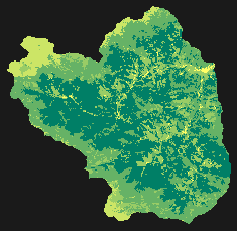

In [18]:
Data['TETIS'] = {}
# leer ascii
read_ascii(rutaTETIS + 'cobveg.asc', datatype='int')
# extraer y recortar datos
cobveg = read_ascii.data.astype('float')
cobveg[cobveg.mask] = np.nan
cobveg = cobveg.data
maskrows = ~np.all(np.isnan(cobveg), axis=1)
maskcols = ~np.all(np.isnan(cobveg), axis=0)
cobveg = cobveg[maskrows,:][:,maskcols]
Data['TETIS'][var] = cobveg.copy()
del cobveg

# extraer atributos
attrs = read_ascii.attributes
# coordenadas
x = np.arange(attrs[2], attrs[2] + attrs[0] * attrs[4], attrs[4])
Data['TETIS']['X'] = x[maskcols]
y = np.arange(attrs[3], attrs[3] + attrs[1] * attrs[4], attrs[4])
Data['TETIS']['Y'] = y[maskrows]

plt.imshow(Data['TETIS'][var], cmap='summer')
plt.axis('off');

#### Unificar resolución de los mapas

In [19]:
# resolución de MODIS
resMODIS = 463.3127165275

In [20]:
Data['TETIS_'] = {}

# 'array' de clases de cobertura
n, m = Data['MODIS'][var].shape[1], Data['MODIS'][var].shape[2]
Data['TETIS_'][var] = np.ones((n, m)) * np.nan
# escoger la clase más frecuente ventana móvil de 5x5 celdas
for i, y in enumerate(Data['MODIS']['Y']):
    for j, x in enumerate(Data['MODIS']['X']):
        maskY = np.where(abs(Data['TETIS']['Y'] - y) < resMODIS / 2)[0]
        maskX = np.where(abs(Data['TETIS']['X'] - x) < resMODIS / 2)[0]
#         print('i: {0}\tj: {1}\tdimensiones de la máscara: ({2},{3})'.format(i, j, len(maskY),
#                                                                             len(maskX)), end='\r')
        aux = Data['TETIS'][var][maskY,:][:,maskX]
        if np.all(np.isnan(aux)):
            continue
        else:
            unq, cnt = np.unique(aux, return_counts=True)
            Data['TETIS_'][var][i,j] = unq[np.argmax(cnt)] 
            
# guardar resto de variables
Data['TETIS_']['X'] = Data['MODIS']['X']
Data['TETIS_']['Y'] = Data['MODIS']['Y']

***
## Análisis
### MODIS

In [ ]:
# video de la cobertura del suelo anual de MODIS
animate3Darray(Data['MODIS'][var], Data['MODIS']['dates'], minmax=[1, 11],
               cblabel=var + ' (' + units + ')', cmap='summer', fps=1,
               pathfile=rutaExport + var + 'deva_MODIS.mp4')

In [23]:
# 'Data frame' con la fracción de cuenca perteneciente a cada clase en ambos mapas
LC = pd.DataFrame(index=TETISclass.keys())
for src in ['MODIS_', 'TETIS_']:
    unq, cnt = np.unique(Data[src][var], return_counts=True)
    mask = ~np.isnan(unq)
    unq, cnt = unq[mask], cnt[mask]
    LC.loc[unq, src] = cnt / np.sum(cnt)
LC.index = [TETISclass[c] for c in TETISclass]

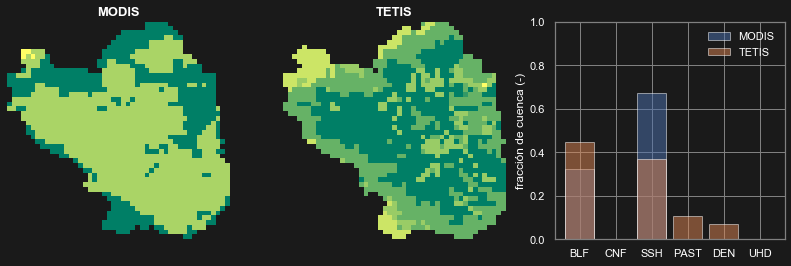

In [24]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 4))

for ax, src in zip(axes, ['MODIS_', 'TETIS_']):
    ax.imshow(Data[src][var], cmap='summer')
    ax.set_title(src[:-1], fontsize=13, fontweight='bold')
    ax.axis('off');  
    axes[2].bar(LC.index, LC[src], alpha=.5, label=src[:-1])

axes[2].set_ylabel('fracción de cuenca (-)', fontsize=12)
axes[2].set_ylim(0, 1)
axes[2].legend(loc=1);

plt.savefig(rutaExport + 'Comparativa usos del suelo MODISvsTETIS.png', dpi=300, tight_layout=True)

Hay un __acuerdo relativamente pobre entre la clasificación de los usos del suelo de MODIS y TETIS__. En ambos casos la clase más frecuente es el basque caducifolio ($BLF$), pero la fracción de cuenca ocupada por esta clase es muy superior en MODIS ($66\%$) que en TETIS ($44\%$). La principal causa de esta sobrevaloración del bosque en MODIS es que asume una lína de bosque a mayor altitud que TETIS, de manera que buena parte de la cuenca considerada arbusto en TETIS es considerada como bosque en MODIS.

A su vez, MODIS infravalora la superficie de terreno desnudo (prácticamente inexistente) y sobrevalora el pasto, considerando como pastos zonas consideradas como arbusto en TETIS.

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
# convertir los dos mapas en una matriz de dos filas y n (nº celdas) conlumnas
y = np.vstack((Data['MODIS_'][var].flatten(),
               Data['TETIS_'][var].flatten()))
# eliminar columnas con algún NaN
y = y[:, ~np.any(np.isnan(y), axis=0)]
# convertir en enteros y transponer
y = y.astype('int').transpose()
y.shape

In [ ]:
# crear 'target arrays' para la función de sklearn
y_true = np.zeros((y.shape[0], len(TETISclass)))
y_score = y_true.copy()
for i in range(y.shape[0]):
    y_true[i,y[i,0] - 1] = 1
    y_score[i,y[i,1] - 1] = 1

In [ ]:
np.sum(y_true, axis=0)

In [ ]:
np.sum(y_score, axis=0)

In [ ]:
# calcuar ROC_AUC
roc_auc_score(y_true, y_score, average='weighted')

In [ ]:
y.transpose()

In [ ]:
len(TETISclass)

In [ ]:
for j, c in enumerate(TETISclass):
    for i in range(y.shape[0]):
        

In [ ]:
y_true